In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns

sns.set()
sns.set_context('poster')

In [2]:
data = sio.loadmat('./kos_doc_data.mat')

In [3]:
counts_train = data["A"]
counts_test = data["B"]
words = data["V"]
counts_train

array([[   1,    2,    1],
       [   1,   15,    1],
       [   1,   28,    1],
       ...,
       [2000, 6689,    1],
       [2000, 6761,    1],
       [2000, 6798,    2]], dtype=uint16)

In [4]:
# this data is document id, word id, word count in the doc
array_counts = np.zeros((2000, len(words)))

# array_counts[doc, word]

for word in counts_train:
    array_counts[word[0]-1, word[1]-1] += word[2]

total_counts = np.sum(array_counts, axis=0)

train_probs = total_counts/sum(total_counts)

train_probs

array([1.47113991e-05, 6.25234463e-05, 4.78120472e-05, ...,
       6.25234463e-05, 1.17691193e-04, 2.20670987e-05])

In [68]:
words

array([[array(['aarp'], dtype='<U4')],
       [array(['abandon'], dtype='<U7')],
       [array(['abandoned'], dtype='<U9')],
       ...,
       [array(['zogbys'], dtype='<U6')],
       [array(['zone'], dtype='<U4')],
       [array(['zones'], dtype='<U5')]], dtype=object)

In [69]:
words_array = np.array([word[0] for word in words[:,0]])
words_array

array(['aarp', 'abandon', 'abandoned', ..., 'zogbys', 'zone', 'zones'],
      dtype='<U40')

In [70]:
array_counts = np.zeros((2000, len(words)))

# array_counts[doc, word]

for word in counts_train:
    array_counts[word[0]-1, word[1]-1] += word[2]

train_word_counts = np.sum(array_counts, axis=0)

train_word_probs = total_counts/sum(total_counts)

train_word_counts_dict = dict(zip(words_array, train_probs))

train_sorted_words = sorted(train_word_counts_dict, key=train_word_counts_dict.get, reverse=True)


### (a)

Text(0, 0.5, 'Word')

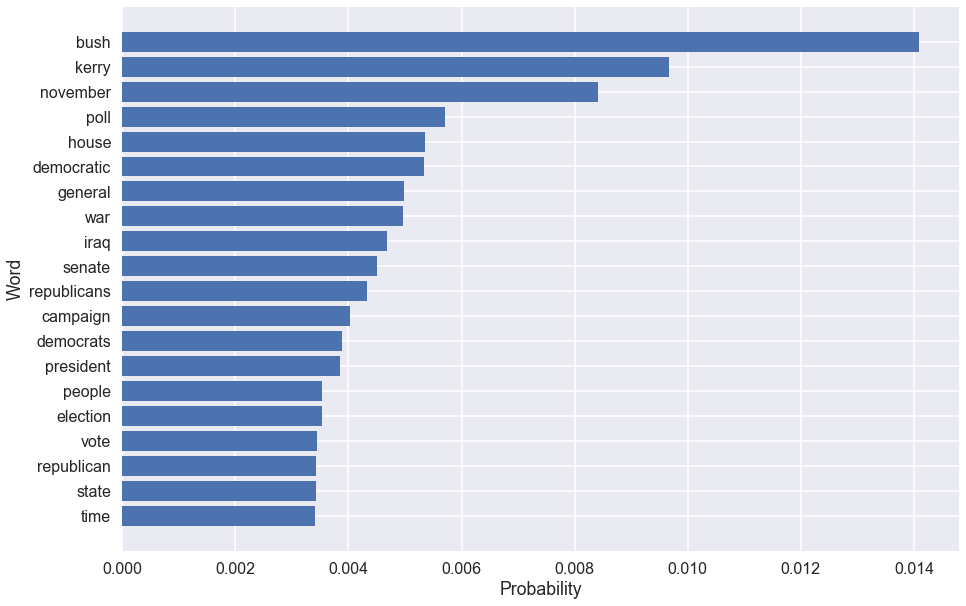

In [177]:
plt.figure(figsize=(15,10))
plt.barh(np.linspace(1, 20, 20), np.flip(list(sorted(train_word_probs, reverse=True))[:20]), tick_label=np.flip(train_sorted_words[:20]))
plt.xlabel("Probability")
plt.ylabel("Word")

'bush' is clearly the highest probability 

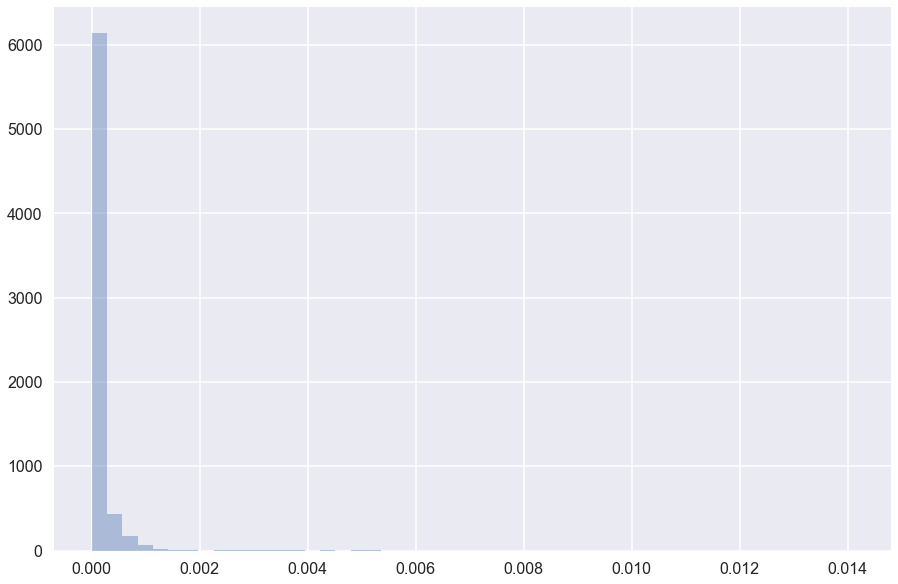

In [90]:
plt.figure(figsize=(15,10))
sns.distplot(train_word_probs, kde=False)

### (b)

symmetric dirichlet prior with a concatenation parameter a on the word probabilities

we can take train word counts and add alpha to all of them

7.856400994608398
7.860854692611317


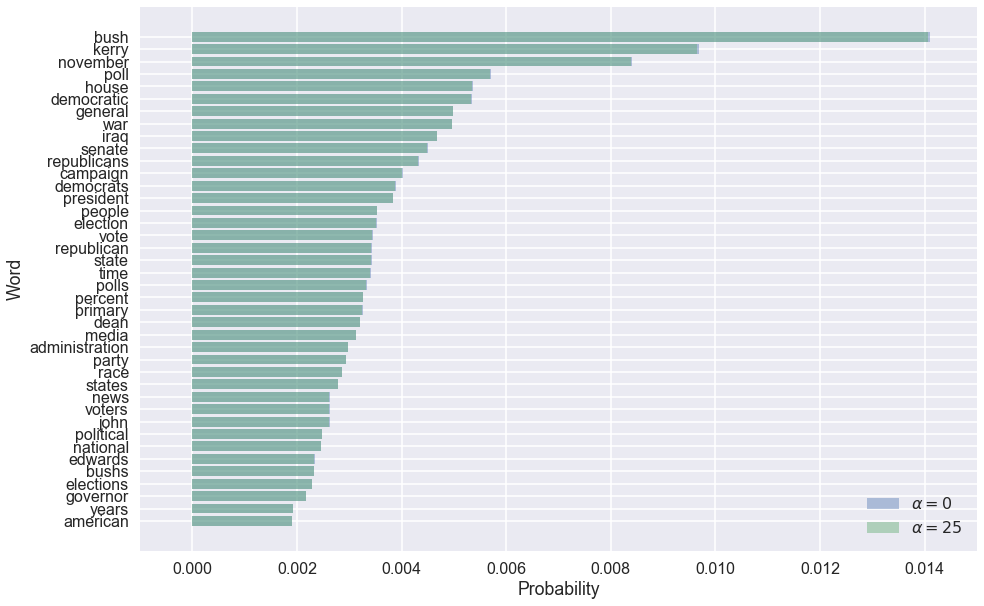

In [8]:
plt.figure(figsize=(15,10))

for alpha in np.linspace(0, 0.1, 2):
    
    b_train_word_counts_dict = {}

    for word in counts_train:
        current_word = words[word[1]-1][0][0]
        if current_word in b_train_word_counts_dict.keys():
            b_train_word_counts_dict[current_word] += word[2]
        else:
            b_train_word_counts_dict[current_word] = word[2] + alpha

    b_train_word_counts = sorted(b_train_word_counts_dict, key=b_train_word_counts_dict.get, reverse=True)

    b_train_word_probs = list(b_train_word_counts_dict.values())/sum(b_train_word_counts_dict.values())
    
    b_entropy = np.sum(-b_train_word_probs * np.log(b_train_word_probs))

    plt.barh(np.linspace(1, 40, 40), np.flip(list(sorted(b_train_word_probs, reverse=True))[:40]), tick_label=np.flip(b_train_word_counts[:40]), alpha=0.4)

plt.xlabel("Probability")
plt.ylabel("Word")
plt.xlim([-0.001,0.015])
plt.legend([r'$\alpha = 0$', r'$\alpha = 25$', r'$\alpha = 50$'])

In [7]:
# Formalise the code a bit with a model class
from numpy import ma

class DocumentMultinomial:
    def __init__(self, alpha=0):
        self.alpha = alpha
    
    def train(self, counts_train, words_train):
        
        self.words = words_train
    
        array_counts = np.zeros((len(counts_train), len(self.words))) + self.alpha

        for word in counts_train:
            array_counts[word[0]-1, word[1]-1] += word[2]

        train_word_counts = np.sum(array_counts, axis=0)

        train_word_probs = train_word_counts/sum(train_word_counts)

        train_words_tup = list(zip(words_array, train_word_probs))

        self.pred_probs = train_word_probs
        self.word_probs = train_words_tup
        
    def test(self, counts_test):
        
        min_word_val = min(counts_test[:,0])
        max_word_val = max(counts_test[:,0])
        
        pred_probs_stack = np.tile(self.pred_probs, (max_word_val-min_word_val+1, 1))
        
        array_counts = np.zeros(pred_probs_stack.shape)

        for word in counts_test:
            
            array_counts[word[0]-min_word_val, word[1]-1] += word[2]

        log_probs_array = np.sum(ma.log(pred_probs_stack).filled(0)*array_counts, axis=1)
        
        total_words = np.sum(array_counts, axis=1)
        
        perplexity_doc = np.exp(-log_probs_array/total_words)
        
        perplexity_total = np.exp(-sum(log_probs_array)/sum(total_words))
            
        return log_probs_array, perplexity_doc, perplexity_total, total_words


### (c)

In [ ]:
model = DocumentMultinomial(alpha=0.1)

model.train(counts_train, words)

In [ ]:
log_probs_test, perplexity_doc_test, perplexity_total_test, total_words_test = model.test(counts_test)
log_probs_test.shape

In [ ]:
log_probs_test

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(perplexity_doc_test)
plt.xlabel("Per-word perplexity")
plt.ylabel("Density")

In [ ]:
sum(total_words_test)

In [ ]:
perplexity_doc_test

### (d)

In [93]:
from bmm import BMM

In [94]:
mixtures_list = []
multis_list = []

for i in range(5):
    print(i)
    bmm_perplexity, bmm_multinomials, mixtures = BMM(counts_train, counts_test, 20, 10, 0.1, 100, seed=i)
    mixtures_list.append(mixtures)
    multis_list.append(bmm_multinomials)

0
1
2
3
4


Text(0, 0.5, 'Mixing proportion')

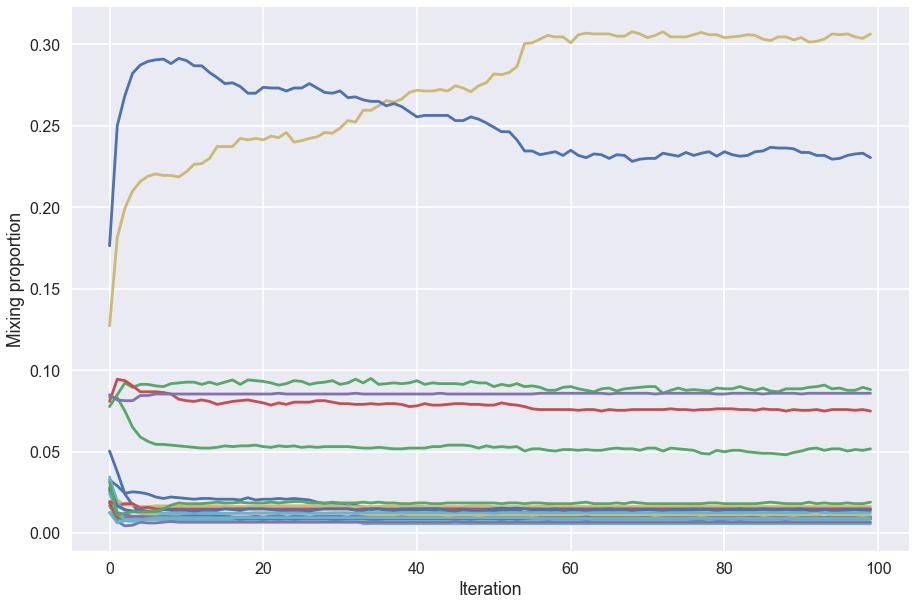

In [95]:
plt.figure(figsize=(15,10))
plt.plot(mixtures_list[3].T)
plt.xlabel("Iteration")
plt.ylabel("Mixing proportion")

having multiple mixing proportions close to 0 suggests the model is overdefined i.e. that K is too large. In an idael case we would have all non-zero proportions

Plot the distribution for each component, compare these for each chain

In [61]:
bmm_multinomials.shape

(6906, 20)

In [33]:
import pandas as pd
from matplotlib import gridspec

In [12]:
np.array(mixtures_list).shape

(5, 20, 100)

Text(0.1, 0.5, 'Mixing proportion')

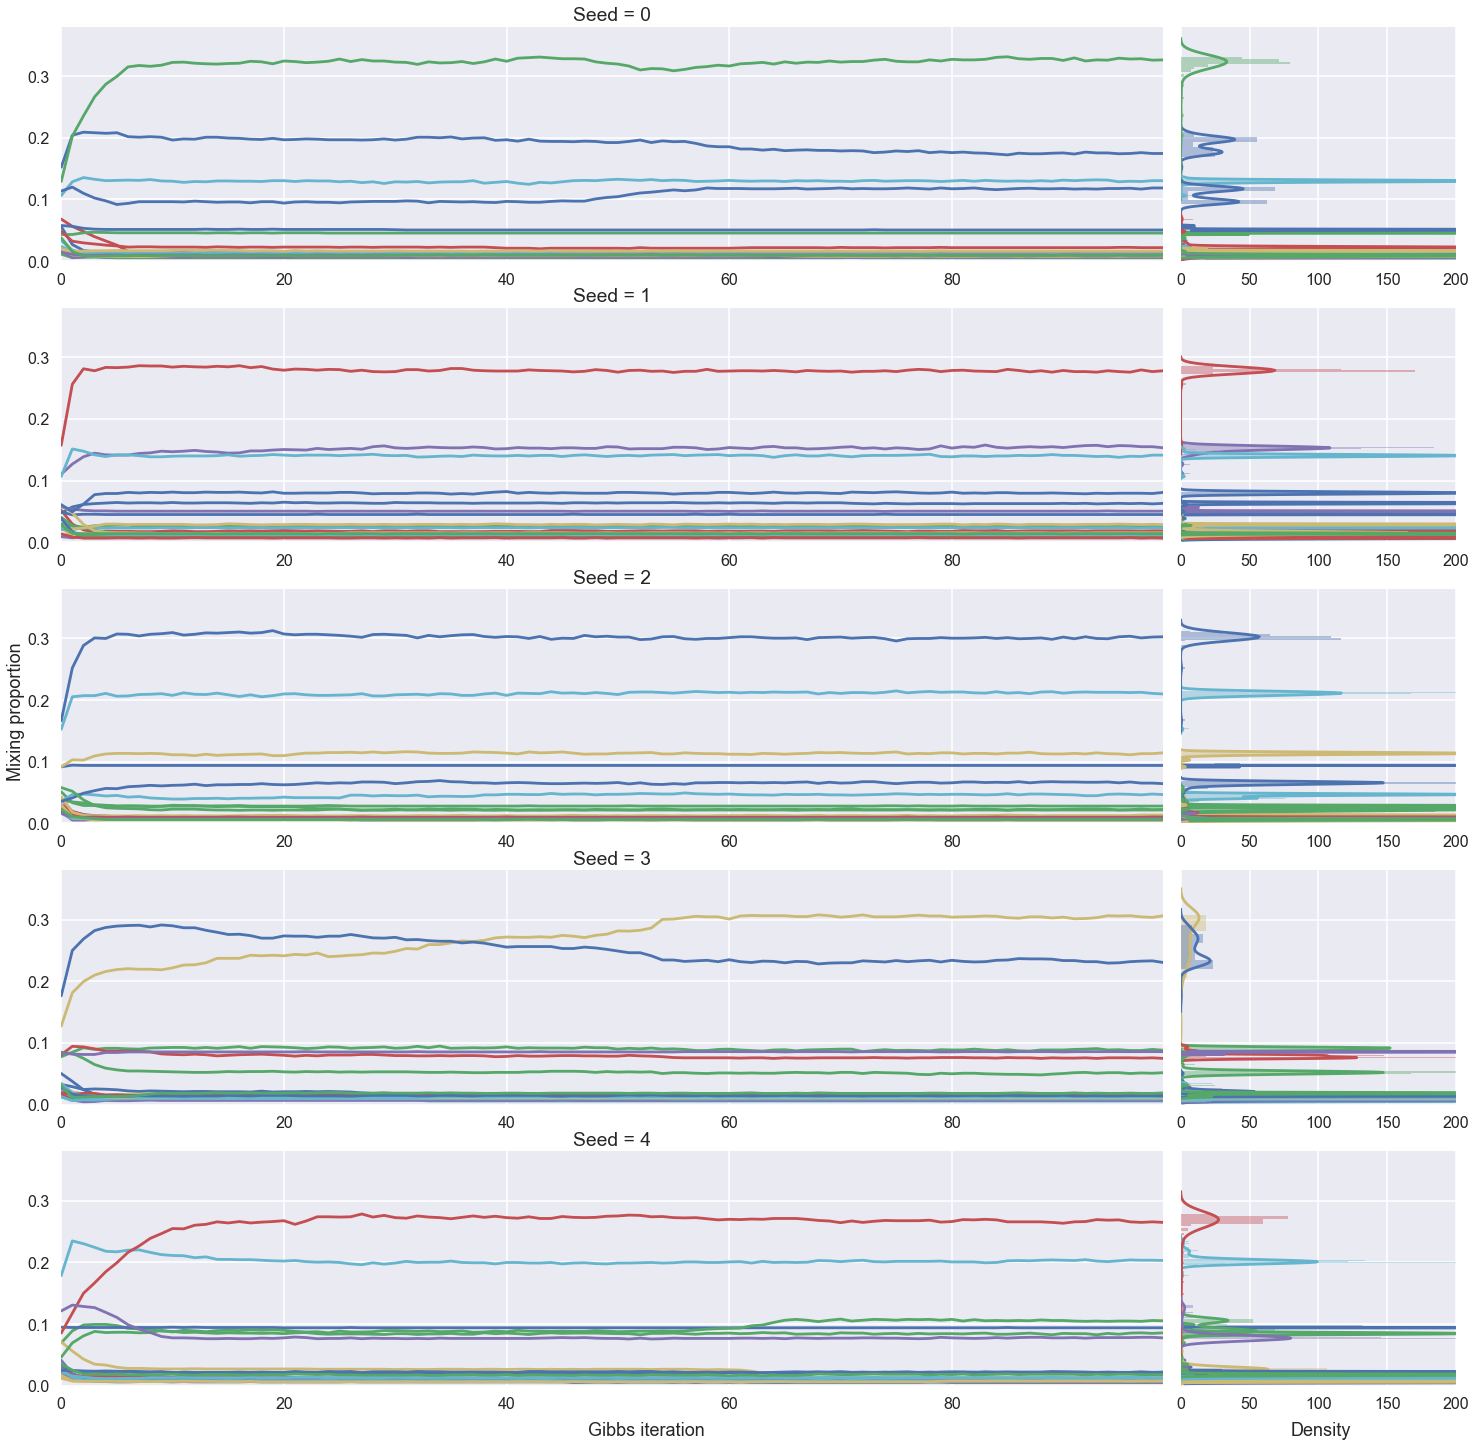

In [60]:
fig = plt.figure(figsize=(25, 25)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[4, 1])
gs.update(wspace=0.025)

for i in range(len(mixtures_list)):
    ax1 = plt.subplot(gs[i,0])
    ax2 = plt.subplot(gs[i,1])
    ax1.title.set_text(f'Seed = {i}')
    ax1.title.set_text(f'Seed = {i}')
    ax1.plot(mixtures_list[i].T)
    for j in range(len(mixtures_list[0])):
        sns.distplot(mixtures_list[i][j], ax=ax2, vertical=True)
    ax2.set_xlim([0,200])
    ax1.set_xlim([0,99])
    ax1.set_ylim([0,0.38])
    ax2.set_ylim([0,0.38])
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(left=False, labelleft=False)
    
#ax[0].legend([r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$', r'$\theta_{4}$', r'$\theta_{5}$', r'$\theta_{6}$', r'$\theta_{7}$', r'$\theta_{8}$', r'$\theta_{9}$', r'$\theta_{10}$'])

fig.text(0.45, 0.1, 'Gibbs iteration', ha='center', va='center', fontsize=18)
fig.text(0.825, 0.1, 'Density', ha='center', va='center', fontsize=18)
fig.text(0.1, 0.5, 'Mixing proportion', ha='center', va='center', rotation='vertical', fontsize=18)

# Setting the values for all axes.

In [100]:
multis_list[0].shape

(6906, 20)

### (e)

In [4]:
from lda import LDA

In [5]:
np.random.seed(0)
lda_perplexity, lda_swk, lda_topic_posts, word_entropy = LDA(counts_train, counts_test, 20, 0.1, 0.1, 50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [6]:
word_entropy.shape

(20, 50)

643
5.481344851463323


Text(0.5, 0, 'Gibbs iteration')

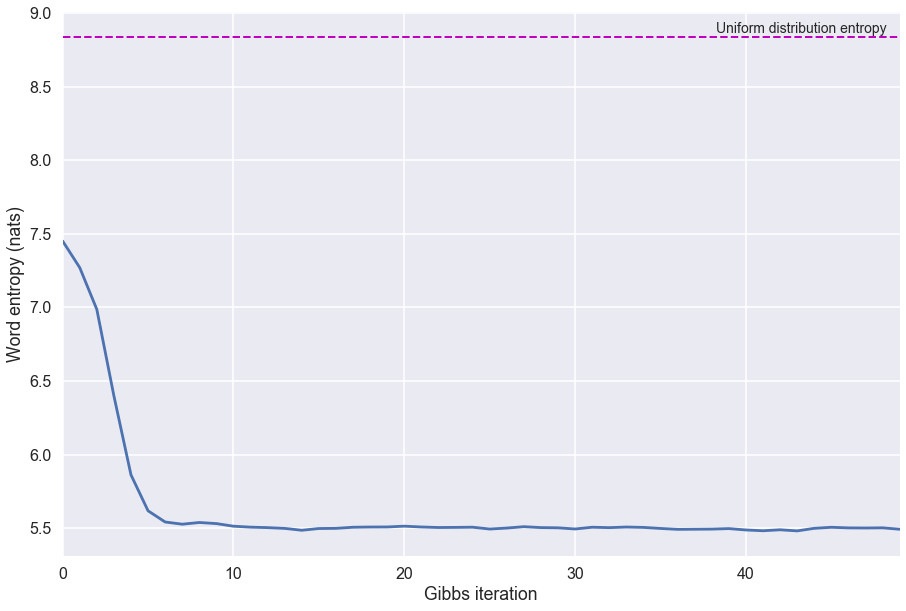

In [47]:
plt.figure(figsize=(15,10))
print(np.argmin(-word_entropy))
print(np.min(-word_entropy))
plt.plot(-word_entropy[12].T)
plt.plot([8.8401]*50, 'm--', lw=2)
plt.text(43.25, 8.89, "Uniform distribution entropy", ha='center', va='center', fontsize=14)
plt.ylabel("Word entropy (nats)")
plt.xlim([0,49])
plt.xlabel("Gibbs iteration")
# topic 13 (index 12) has the lowest entropy

We see the entropies of some topics decrease from the initialisation for specialised topics. Since our model is overdefined as we mentioned before, we see the entropy of some topics increase, as they become more general.

Increasing alpha increases the starting word entropy. The chain begins by assigning words to topics at random, sampling from a uniform distribution and then rounding. Since occurrences of words are assigned uniformly to topics, the initial word entropy should therefore be close to the entropy of the multinomial based on counts alone. Some entropies increase as they move more towards a uniform distribution.

For a multinomial based on counts with alpha=0.1 as in the lda experiment, the word entropy is 8.173512969187277. This corresponds with the starting point for the entropies in each topic of the LDA runs. Entropy for a uniform distribution over words is 8.8401. This can be seen in Figure 8.

In [120]:
uniform_dist = np.ones(len(words))/ len(words)
unif_entropy = -np.sum(uniform_dist*np.log(uniform_dist))
unif_entropy

8.840145877949938

In [8]:
lda_topic_posts.shape

(2000, 20, 50)

(0, 49)

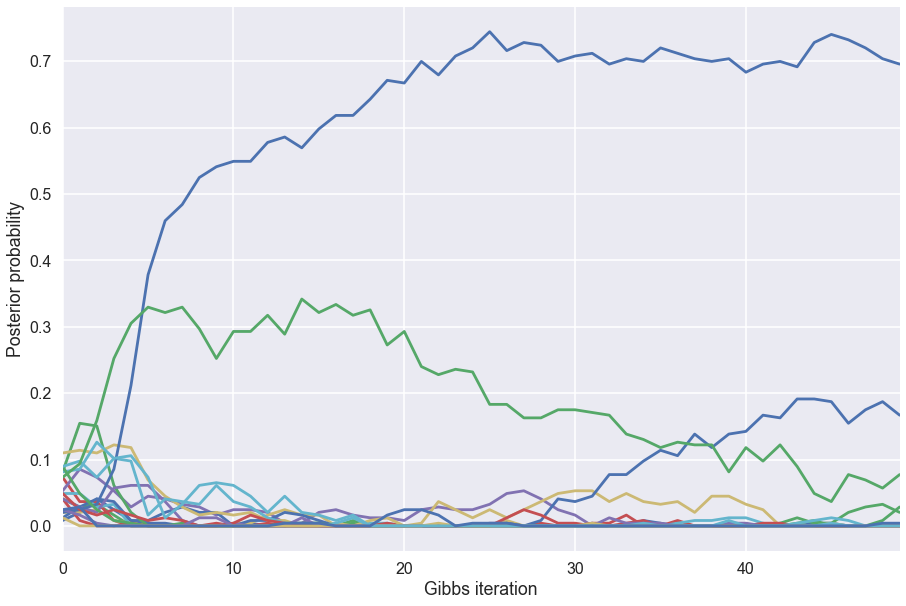

In [98]:
plt.figure(figsize=(15,10))
plt.plot(lda_topic_posts[3].T)
# topic index 12 (topic 13) has the highest value for document 4 (index 3).
# plt.legend([r'$\theta_{4, 1}$', r'$\theta_{4, 2}$', r'$\theta_{4, 3}$', r'$\theta_{4, 4}$', r'$\theta_{4, 5}$'])
plt.xlabel("Gibbs iteration")
plt.ylabel("Posterior probability")
plt.xlim([0,49])

In [25]:
# swk is words x topics

topic_word_posteriors = (lda_swk + 10) / np.sum(lda_swk + 10, axis=0)
topic_word_posteriors[:, 12]

array([0.0001178, 0.0001178, 0.0001178, ..., 0.0001178, 0.0001178,
       0.0001178])

(-0.001, 0.025)

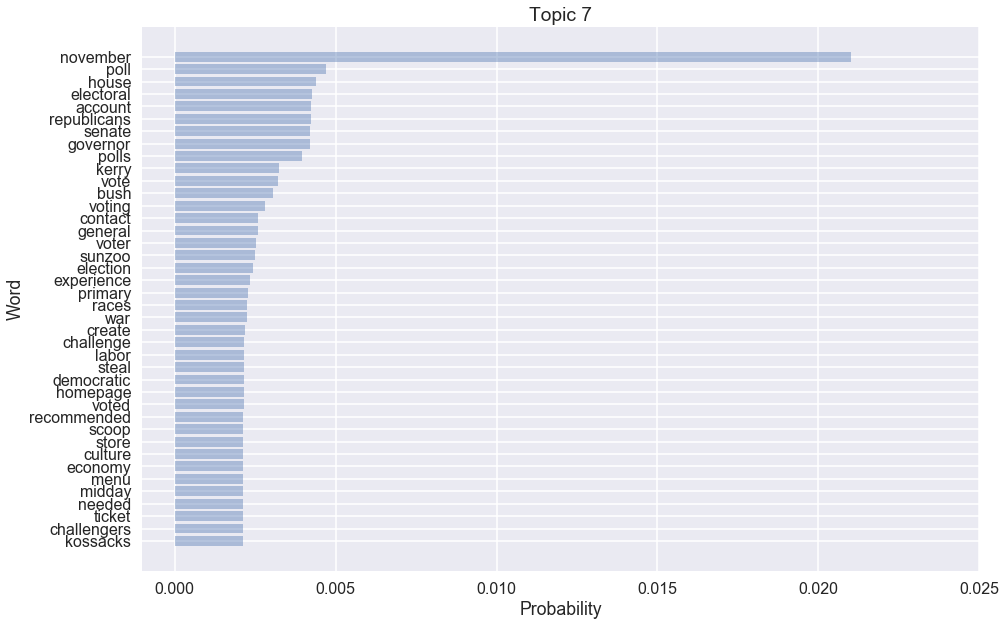

In [121]:
plt.figure(figsize=(15,10))
    
lda_train_word_counts_dict = {}

for i, word in enumerate(topic_word_posteriors[:,12]):
    current_word = words[i][0][0]
    lda_train_word_counts_dict[current_word] = word

lda_train_word_counts = sorted(lda_train_word_counts_dict, key=lda_train_word_counts_dict.get, reverse=True)

lda_train_word_probs = list(lda_train_word_counts_dict.values())

plt.barh(np.linspace(1, 40, 40), np.flip(list(sorted(lda_train_word_probs, reverse=True))[:40]), tick_label=np.flip(lda_train_word_counts[:40]), alpha=0.4)

plt.xlabel("Probability")
plt.ylabel("Word")
plt.title("Topic 13")
plt.xlim([-0.001,0.025])

Text(0, 0.5, 'Perplexity')

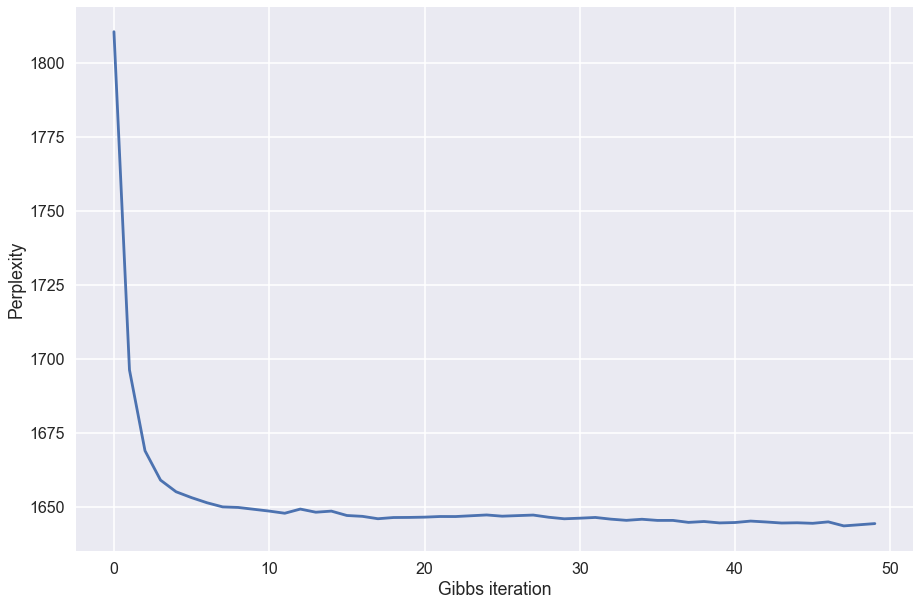

In [64]:
plt.figure(figsize=(15,10))
plt.plot(lda_perplexity)
plt.xlabel("Gibbs iteration")
plt.ylabel("Perplexity")